In [1]:
import sys
sys.path.append('/home/administrator/repos/few-shot-text-classification')
sys.path.append('/home/administrator/repos/utopics')

In [2]:
import os
import secrets
from tqdm import tqdm

import torch

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
from fewshot.data.utils import Dataset

from fewshot.data.loaders import load_or_cache_data

from fewshot.embeddings.word_embeddings import (
    load_word_vector_model,
    get_topk_w2v_vectors,
    get_word_embeddings
)
from fewshot.embeddings.sentence_embeddings import (
    load_transformer_model_and_tokenizer,
    get_sentence_embeddings,
)

from fewshot.models.on_the_fly import OLS_with_l2_regularization

from fewshot.eval import predict_and_score, simple_topk_accuracy

from fewshot.utils import (
    fewshot_filename,
    torch_load,
    torch_save,
    pickle_load,
    pickle_save,
    to_tensor,
    to_list,
)

In [4]:
from src.datasets.ESG.label_set import ESG_Labels, ESG_Labels_ALL

In [5]:
for i, l in enumerate(ESG_Labels_ALL):
    print(i, l)

0 Cyber Risk
1 Product Quality
2 Pollution Management
3 Class Action
4 Clean Technology
5 ESG Commentary
6 Ethics and Anti-Corruption
7 Corporate Philanthropy
8 Supply Chain
9 Legal Regulatory
10 Management Structure
11 Human Capital
12 Reputational Profile
13 Environmental Commentary
14 Workplace Safety
15 Community Engagement
16 Climate Risk
17 Harassment and Assault
18 Transparency and Disclosure
19 Shareholder Engagement
20 Diversity and Inclusion
21 Governance Commentary
22 Access and Affordability
23 Resource and Biodiversity Conservation
24 Environmental Regulation


In [6]:
ESG_Labels_ALL.index('Climate Risk')

16

In [7]:
COL_SENTENCE   = 'sentence_text'
COL_EVENT_NAME = 'event_name'
COL_LABEL      = 'label'

In [8]:
df_events = pd.read_csv('/home/administrator/Topics/BigQuery/DataFrames/df_events.csv')

In [9]:
df_events.sample().T

,14409
model_id,2776
symbology_id,05JLQY-E
creation_time_utc,2021-06-18 18:31:41 UTC
event_time_utc,2021-06-17 11:30:00 UTC
provider_document_id,45193105023
provider_source_link,https://ct.moreover.com/?a=45193105023&p=4y7&v...
provider_license,['LexisNexis Licensed']
author_name,NaN
provider_display_document_title,Investec: Financing transaction to enhance wat...
provider_publication_source,Indian Banking News


In [10]:
df_events[COL_LABEL] = df_events[COL_EVENT_NAME].apply(ESG_Labels_ALL.index)

In [11]:
df_events.shape

(23000, 24)

In [12]:
df_labeled_sentences = df_events.drop_duplicates(subset=[COL_SENTENCE, COL_LABEL])
df_labeled_sentences.shape

(1039, 24)

In [13]:
df_labeled_sentences.to_csv('/home/administrator/Topics/BigQuery/DataFrames/df_labeled_sentences.csv')

/home/administrator/.local/share/virtualenvs/few-shot-text-classification-TZAlgmbz/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


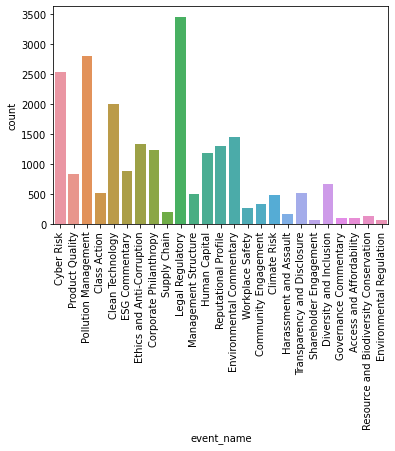

In [14]:
sns.countplot(df_events[COL_EVENT_NAME])
plt.xticks(rotation=90);

/home/administrator/.local/share/virtualenvs/few-shot-text-classification-TZAlgmbz/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


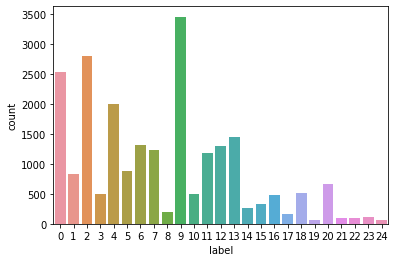

In [15]:
sns.countplot(df_events[COL_LABEL]);

In [18]:
dataset = Dataset(
    examples=df_labeled_sentences[COL_SENTENCE].tolist(),
    labels=df_labeled_sentences[COL_LABEL].tolist(),
    categories=ESG_Labels_ALL,
)

In [19]:
dataset.examples[0]

'Volkswagen and Audi have been hit by a data breach that exposed the contact information and personal details of customers in the U.S. and Canada.'

In [20]:
dataset.examples[1]

"GM recalls vehicles for issue with air bag light WASHINGTON - The U.S. government's highway safety agency approved a request by General Motors to recall four 2021 vehicle makes because of a malfunctioning air bag warning light."

In [21]:
secrets.choice(dataset.examples)

'Polaris accelerates sustainability efforts'

In [22]:
secrets.choice(dataset.examples)

"While they were successful in creating a temporary halt to construction, they were brutally arrested by the local sheriff's department (paid for by Enbridge) sending some to the hospital."

In [23]:
secrets.choice(list(zip(dataset.examples, df_labeled_sentences[COL_EVENT_NAME])))

('"On a corporate level, Sime Darby Plantations and IOI Corporation both have a No Deforestation, No Peat, No Exploitation (NDPE) policy," it noted.',
 'Resource and Biodiversity Conservation')

In [24]:
score = predict_and_score(dataset)

/home/administrator/repos/few-shot-text-classification/fewshot/data/utils.py:81: UserWarning: Should run dataset.calc_sbert_embeddings() first.  In the future this will fail.
  "Should run dataset.calc_sbert_embeddings() first.  In the future this will fail."
Computing sentence representations: 100%|██████████| 67/67 [00:12<00:00,  5.29it/s]


In [25]:
score

22.617901828681426

# ZMap

## W2V

In [26]:
w2v_model = load_word_vector_model(small=True)

In [27]:
w2v_model

In [28]:
w2v_model.index2entity[:20]

['</s>',
 'in',
 'for',
 'that',
 'is',
 'on',
 '##',
 'The',
 'with',
 'said',
 'was',
 'the',
 'at',
 'not',
 'as',
 'it',
 'be',
 'from',
 'by',
 'are']

In [29]:
k = 100000 # most frequent words
w2v_vectors, vocabulary = get_topk_w2v_vectors(w2v_model, k=k, return_word_list=True)
vocabulary_filename = fewshot_filename("my_data/w2v", "w2v_vocab_sbert_embeddings.pt")

In [30]:
len(w2v_vectors)

100000

## S-BERT

In [31]:
model, tokenizer = load_transformer_model_and_tokenizer("deepset/sentence_bert")

In [32]:
sbert_vectors = torch_load(vocabulary_filename)['embeddings']

## Score

In [33]:
Zmap_20000 = OLS_with_l2_regularization(sbert_vectors[:20000], to_tensor(w2v_vectors[:20000]))
Zmap_50000 = OLS_with_l2_regularization(sbert_vectors[:50000], to_tensor(w2v_vectors[:50000]))

In [35]:
Zmap_20000.shape, Zmap_50000.shape

(torch.Size([768, 300]), torch.Size([768, 300]))

In [ ]:
[
    predict_and_score(dataset),
    predict_and_score(dataset, [Zmap_20000]),
    predict_and_score(dataset, [Zmap_50000]),
    predict_and_score(dataset, [torch.rand_like(Zmap)]),
    predict_and_score(dataset, [torch.empty_like(Zmap)]),
    predict_and_score(dataset, [torch.zeros_like(Zmap)]),
    predict_and_score(dataset, [torch.ones_like(Zmap)]),
]